In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/tschiwy/ExTRA/")
import ExTRA as ex

ExTRA  imported correctly


# HIP Mockdata

In [2]:
#The gaia standard model solution can usually be read of online.
#However
#For the purpose of showing, here is just a simple example:

#model used in mockdata.ipynb:
asc=20
dec=-10
parallax=200
mu_a_star=-100
mu_d=+300


gaia=np.array([asc,dec,parallax,mu_a_star,mu_d])

J2016=2457389.0
J1991=2448349.0625


#Assuming hip and gaia got the same solution:

hip_standard=np.zeros(5)


hip_standard[0],hip_standard[1]=ex.pos_recalc(gaia,J2016,J1991)
#hip standard epoch is J1991


hip_standard[2:5]=np.array(gaia[2:5])

print(hip_standard)

[  20.0006875  -10.0020625  200.        -100.         300.       ]


In [3]:
HIP=ex.hip_read("mock_HIP.txt")
hip_ad=HIP[0] #A3,A4,A5,A6,A7,A8,A9=HIP[0] this is needed for fitting !!!


A3,A4,A5,A6,A7,A8,A9=HIP[0] 
t_hip=HIP[1] #time of measurements in JD, for plots

# RV Mockdata

In [4]:
RV_data=ex.RV_read("mock_RV.txt")
t_RV,RV,RV_err=RV_data #timestamps,RVs,error

## Working with the data

### 1) Plotting HIP data

In [5]:
x,x_err,y,y_err=ex.hip_2d(hip_ad) #Rotates the HIP measurements into the RA,Dec frame.


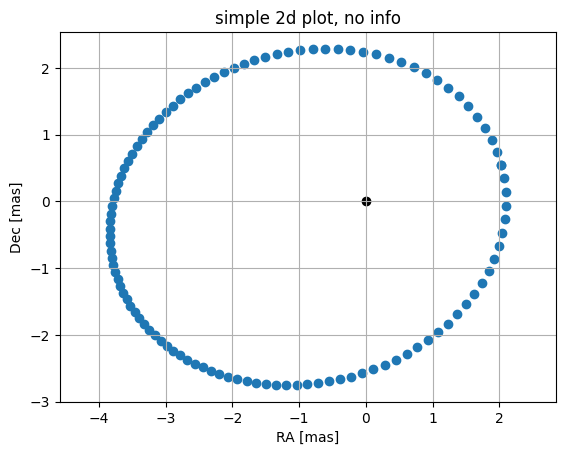

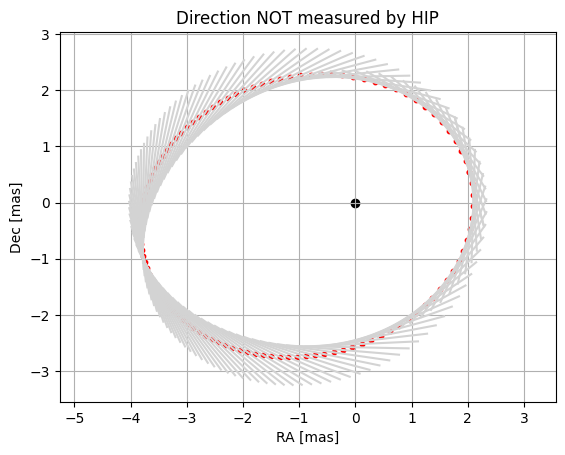

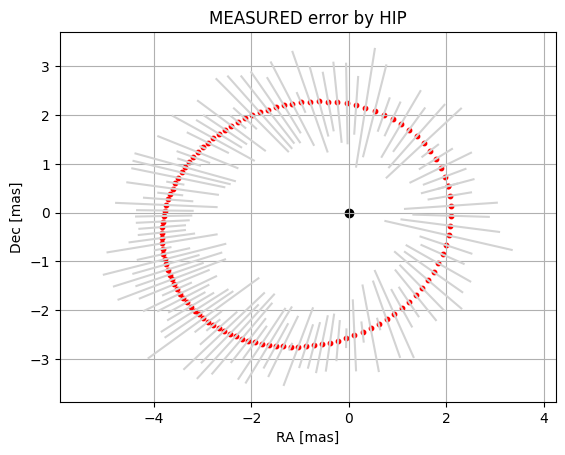

In [7]:
plt.title("simple 2d plot, no info")
plt.scatter(x,y)
plt.scatter(0,0,color="k")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.axis("equal")
plt.grid()
plt.show()




ex.plot_hip(x,x_err,y,y_err)

plt.title("Direction NOT measured by HIP")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.scatter(0,0,color="k")
plt.axis("equal")
plt.grid()
plt.show()




ex.plot_hip_err(x,x_err,y,y_err,s=10)

plt.title("MEASURED error by HIP")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.scatter(0,0,color="k")
plt.axis("equal")
plt.grid()
plt.show()


### 2) Fitting 

#### 2.1) just HIP (important for Trifon)

In [8]:
#For simplicity i assume gaia and HIP to have the same exact solution, but usually the gaia solution is different from the HIP
#solution and way more accurate
#standard epochs
J1991=2448349.0 #1991.25
J2000=2451545.0
J2016=2457389.0


In [9]:
#Parameters #taken from the datawrite file
correction=np.array([3,0,0,0,0])

P=550
e=0.3
om=np.radians(0)
i=np.radians(30)
Om=np.radians(75)
T0=J1991+900 #900 days after standard 1991
a=3

In [10]:
#just the loglik , as example
ex.L_hip(hip_ad,hip_standard,gaia, #Data
         correction,P,e,om,i,Om,T0,a, #parameters
         s_hip=0)#jitter

np.float64(39.18291878309101)

In [11]:
#function you want to miniize
def Hip_min(theta,hip_ad,hip_standard,gaia):

    P,e,om,i,Om,T0,a,del_asc,del_dec,del_para,del_mua,del_mud=theta

    correction=del_asc,del_dec,del_para,del_mua,del_mud

    L=ex.L_hip(hip_ad,hip_standard,gaia,correction,P,e,om,i,Om,T0,a)

    return L*1000

In [12]:
#bounds
orbbnds=(P-300,P+300),(0,0.9),(-np.pi,np.pi),(0,np.pi/2),(-np.pi,np.pi),(T0-300,T0+300),(0,10)
standbnds=(-10,10),(-10,10),(-10,10),(-10,10),(-10,10)
bnds=orbbnds+standbnds

In [13]:

#guess
orb=np.array([P,e,om,i,Om,T0,a])
stand_corr=correction
x0=np.concatenate([orb,stand_corr])

In [14]:
from scipy.optimize import minimize

In [15]:

fit=minimize(Hip_min,x0,args=(hip_ad,hip_standard,gaia),bounds=bnds,tol=1e-15,options={"maxiter":1e6,"maxfun":1e8},method="L-BFGS-B")
print(fit)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 39182.91872564344
        x: [ 5.500e+02  3.000e-01  7.974e-06  5.236e-01  1.309e+00
             2.449e+06  3.000e+00  3.000e+00  0.000e+00  0.000e+00
             1.244e-06 -1.173e-06]
      nit: 16
      jac: [-1.310e-02  4.729e-02  1.455e-03 -8.731e-03  0.000e+00
             2.976e-03  2.401e-02  0.000e+00  0.000e+00  0.000e+00
             1.310e-02  1.528e-02]
     nfev: 260
     njev: 20
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>


In [16]:
fit.x-x0

array([ 5.56698069e-07,  2.05271968e-06,  7.97381435e-06, -6.18975960e-06,
        0.00000000e+00, -2.64961272e-07,  1.59066656e-07,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.24389769e-06, -1.17256398e-06])

In [17]:
gaia_correct=ex.stand_correct(gaia,correction)
new_residuals=ex.abs_res(A8,gaia_correct,hip_standard,hip_ad)

In [18]:
x,x_err,y,y_err=ex.hip_2d(hip_ad) #Rotates the HIP measurements into the RA,Dec frame.
